## Solver Usage Notebook

This notebook demonstrates how to use our custom Solver to perform precise computations on stochastic processes. We'll walk through the pipeline for employing the solver, and then illustrate its capabilities with three examples:

1. **Non-Markovian** example with 4 time steps to showcase convergence.

2. **Markovian example (scaling)** demonstrating linear scaling with time steps.

3. **Markovian example (unknown closed form)** where we infer the value without knowing the analytic solution.

In [1]:
%load_ext autoreload
%autoreload 2
import sys
import numpy as np
import time
import matplotlib.pyplot as plt
sys.path.append('../')
random_seed = 5

from pnot.utils import adapted_wasserstein_squared, matrixL2paths
from pnot import nested_ot

## Example 1: Convergence of a Non-Markovian Process

We begin with an important remark. In the non-Markovian setup, we consider a non-recombining structure—that is, two paths that reach the same value at a future time step but have different pasts are treated as distinct. This contrasts with the Markovian case, where only the previous time step is considered.

As a consequence, when the time horizon increases, the number of distinct paths grows exponentially, making the problem intractable due to the massive sampling required.

## Methodology

1. **Budget**  
   Fix a max runtime (e.g. 5 min or 1 h)

2. **Grid (Δx)**  
   Match the process support (e.g. [–1, 1] vs. [0, 1600]).  (Markovian allows much smaller grids.)

   – Too large ⇒ coarse  
   – Too small ⇒ many paths → slow

4. **Trade‑off**  
   ↓ Δx ⇒ ↑ paths needed ⇒ ↑ runtime

5. **Error Estimate**  
   Error in the limit value ≈ (number of time steps) × Δx  
   _E.g._ 4 steps × 0.2 = 0.8

6. **Calibration**  
   • Run low‑path sims at various Δx
   • Decrease Δx until you hit your budget


## Setup

In [2]:
sample_sizes = [1000, 4000, 8000, 12000, 16000, 20000, 25000, 30000, 35000, 40000, 50000, 60000]
grid_size = 0.2
n_runs = 10

# Define matrices (dimension 4)
L = np.array([[1, 0, 0, 0],
              [2, 2, 0, 0],
              [1, 1, 3, 0],
              [2, 2, 1, 2]])

M = np.array([[1, 0, 0, 0],
              [2, 1, 0, 0],
              [3, 2, 1, 0],
              [4, 3, 2, 1]])

L = 
[[1 0 0 0]
 [2 2 0 0]
 [1 1 3 0]
 [2 2 1 2]]
M = 
[[1 0 0 0]
 [2 1 0 0]
 [3 2 1 0]
 [4 3 2 1]]
Theoretical AW_2^2:  17.0


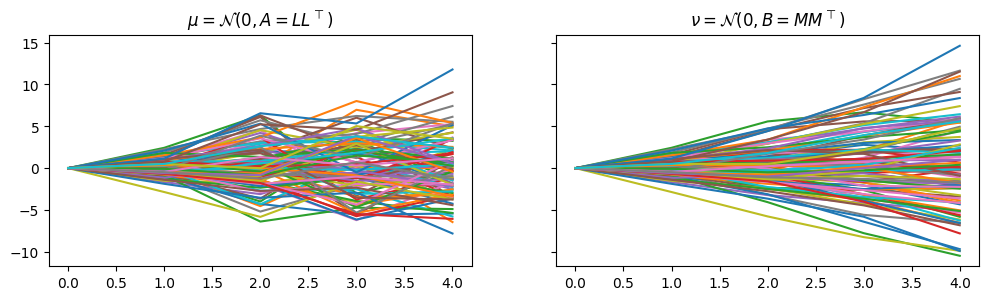

In [3]:
X ,A = matrixL2paths(L, sample_sizes[0], seed = random_seed)
print('L = ')
print(L)

Y,B = matrixL2paths(M, sample_sizes[0], seed = random_seed)
print('M = ')
print(M)

awd2square = adapted_wasserstein_squared(A, B)
print("Theoretical AW_2^2: ", awd2square)

fig, ax = plt.subplots(1,2, figsize = [12,3], sharey=True)
ax[0].plot(X[:,:100])
ax[1].plot(Y[:,:100])
ax[0].set_title(r'$\mu = \mathcal{N}(0,A = LL^\top)$')
ax[1].set_title(r'$\nu = \mathcal{N}(0,B = MM^\top)$')
plt.show()

## Experiments

In [4]:
top_seed = 42  # Set this to any fixed integer for reproducibility
rng = np.random.default_rng(top_seed)

results = {}

for n_sample in sample_sizes:
    distances_runs = np.zeros(n_runs)
    times_runs = np.zeros(n_runs)

    print(f"\nRunning experiments for sample size: {n_sample}")

    for run in range(n_runs):
        seed1 = rng.integers(0, 10000)
        
        # Generate sample paths
        X, A = matrixL2paths(L, n_sample, seed=seed1)
        Y, B = matrixL2paths(M, n_sample, seed=seed1)

        

        t_start = time.perf_counter()
        AW_2square = nested_ot(X, Y, grid_size, markovian = False, num_threads=800) # number of threads very dependent on the machine (here 42 core AMD cpu) and not sure optimal here
        elapsed = time.perf_counter() - t_start

        distances_runs[run] = AW_2square
        times_runs[run] = elapsed

        print(f"Sample size {n_sample}, Run {run+1}: AW_2^2 = {AW_2square:.4f}, Time = {elapsed:.4f} s")

    results[n_sample] = {"distances": distances_runs,
                         "times": times_runs,
                         "benchmark": awd2square}


Running experiments for sample size: 1000
Sample size 1000, Run 1: AW_2^2 = 17.7759, Time = 0.1338 s
Sample size 1000, Run 2: AW_2^2 = 18.5611, Time = 0.1099 s
Sample size 1000, Run 3: AW_2^2 = 17.5784, Time = 0.1188 s
Sample size 1000, Run 4: AW_2^2 = 18.0215, Time = 0.1122 s
Sample size 1000, Run 5: AW_2^2 = 18.2389, Time = 0.0942 s
Sample size 1000, Run 6: AW_2^2 = 17.6988, Time = 0.1027 s
Sample size 1000, Run 7: AW_2^2 = 19.3742, Time = 0.1074 s
Sample size 1000, Run 8: AW_2^2 = 19.3091, Time = 0.1020 s
Sample size 1000, Run 9: AW_2^2 = 18.4039, Time = 0.1049 s
Sample size 1000, Run 10: AW_2^2 = 17.8971, Time = 0.1033 s

Running experiments for sample size: 4000
Sample size 4000, Run 1: AW_2^2 = 18.3446, Time = 0.9876 s
Sample size 4000, Run 2: AW_2^2 = 18.5972, Time = 0.9935 s
Sample size 4000, Run 3: AW_2^2 = 18.4649, Time = 1.0084 s
Sample size 4000, Run 4: AW_2^2 = 18.3998, Time = 1.0082 s
Sample size 4000, Run 5: AW_2^2 = 18.4033, Time = 1.0187 s
Sample size 4000, Run 6: AW_

## Plotting


Aggregated Results:
Sample Size: 1000
  Mean AW_2^2: 18.2859 ± 0.6041
  Mean Time: 0.1089 s ± 0.0104 s
  Mean Absolute Error: 1.2859 ± 0.6041
  Benchmark: 17.0000

Sample Size: 4000
  Mean AW_2^2: 18.4138 ± 0.1434
  Mean Time: 0.9884 s ± 0.0277 s
  Mean Absolute Error: 1.4138 ± 0.1434
  Benchmark: 17.0000

Sample Size: 8000
  Mean AW_2^2: 18.2306 ± 0.1847
  Mean Time: 2.8099 s ± 0.0353 s
  Mean Absolute Error: 1.2306 ± 0.1847
  Benchmark: 17.0000

Sample Size: 12000
  Mean AW_2^2: 18.0829 ± 0.1120
  Mean Time: 5.0207 s ± 0.0656 s
  Mean Absolute Error: 1.0829 ± 0.1120
  Benchmark: 17.0000

Sample Size: 16000
  Mean AW_2^2: 18.0989 ± 0.0782
  Mean Time: 7.3647 s ± 0.0920 s
  Mean Absolute Error: 1.0989 ± 0.0782
  Benchmark: 17.0000

Sample Size: 20000
  Mean AW_2^2: 18.0029 ± 0.1591
  Mean Time: 9.7891 s ± 0.1228 s
  Mean Absolute Error: 1.0029 ± 0.1591
  Benchmark: 17.0000

Sample Size: 25000
  Mean AW_2^2: 17.9349 ± 0.0983
  Mean Time: 12.8249 s ± 0.1452 s
  Mean Absolute Error: 0.93

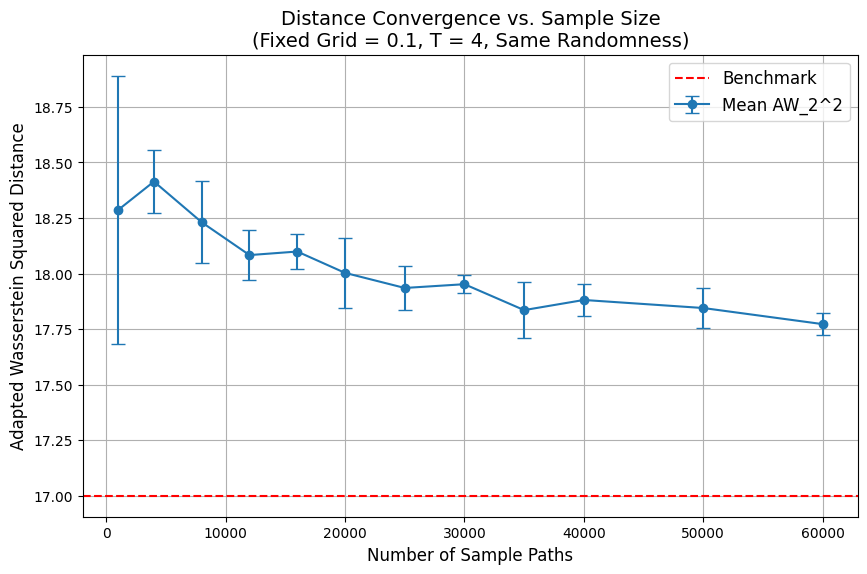

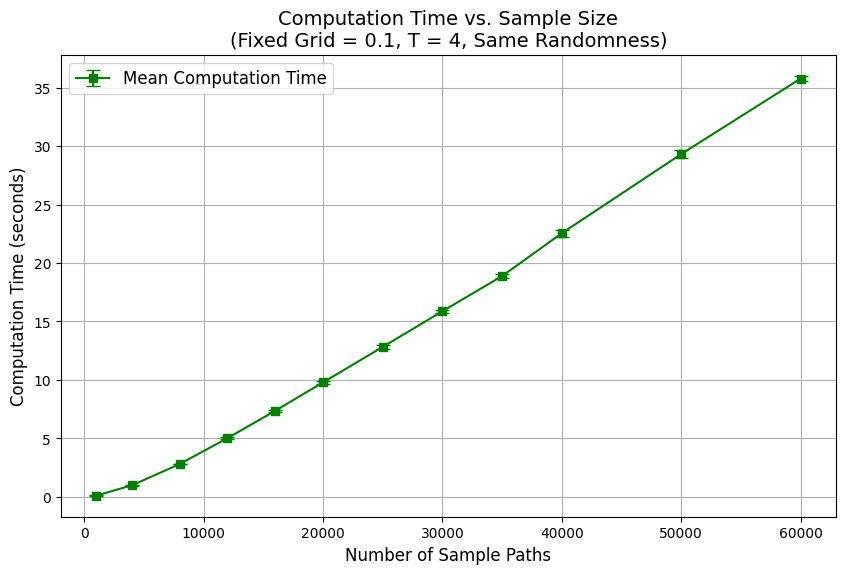

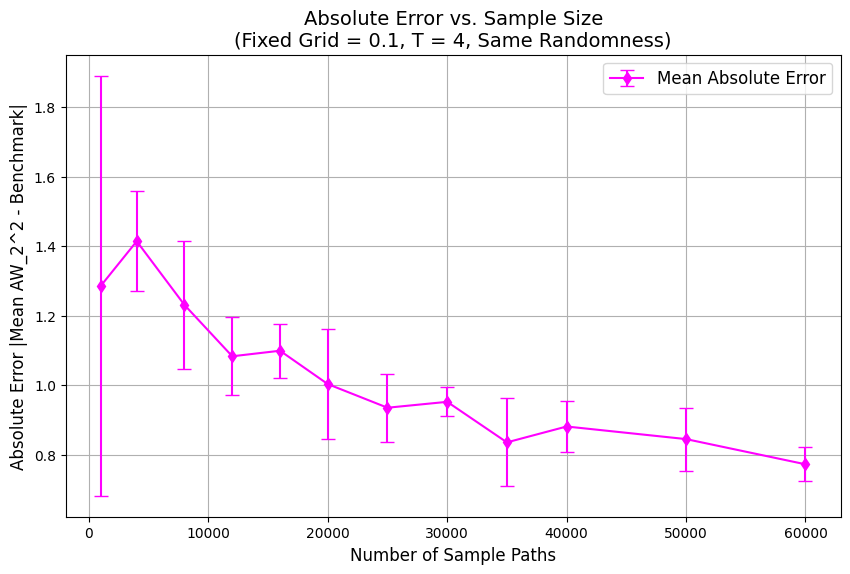

In [5]:
print("\nAggregated Results:")
aggregated = {}
for n_sample in sorted(results.keys()):
    data = results[n_sample]
    dists = data["distances"]
    times = data["times"]
    bench = data["benchmark"]
    mean_dist = np.mean(dists)
    std_dist = np.std(dists)
    mean_time = np.mean(times)
    std_time = np.std(times)
    abs_errors = np.abs(dists - bench)
    mean_abs_err = np.mean(abs_errors)
    std_abs_err = np.std(abs_errors)
    aggregated[n_sample] = {
        "mean_distance": mean_dist,
        "std_distance": std_dist,
        "mean_time": mean_time,
        "std_time": std_time,
        "mean_abs_error": mean_abs_err,
        "std_abs_error": std_abs_err,
        "benchmark": bench
    }
    print(f"Sample Size: {n_sample}")
    print(f"  Mean AW_2^2: {mean_dist:.4f} ± {std_dist:.4f}")
    print(f"  Mean Time: {mean_time:.4f} s ± {std_time:.4f} s")
    print(f"  Mean Absolute Error: {mean_abs_err:.4f} ± {std_abs_err:.4f}")
    print(f"  Benchmark: {bench:.4f}\n")


sample_list = sorted(aggregated.keys())
mean_distances = [aggregated[n]["mean_distance"] for n in sample_list]
std_distances = [aggregated[n]["std_distance"] for n in sample_list]
mean_times = [aggregated[n]["mean_time"] for n in sample_list]
std_times = [aggregated[n]["std_time"] for n in sample_list]
mean_abs_errors = [aggregated[n]["mean_abs_error"] for n in sample_list]
std_abs_errors = [aggregated[n]["std_abs_error"] for n in sample_list]
benchmark = aggregated[sample_list[0]]["benchmark"]  # assuming benchmark is the same across sizes

# Plot 1: Distance Convergence
plt.figure(figsize=(10, 6))
plt.errorbar(sample_list, mean_distances, yerr=std_distances, fmt="o-", capsize=5, label="Mean AW_2^2")
plt.axhline(y=benchmark, color="red", linestyle="--", label="Benchmark")
plt.xlabel("Number of Sample Paths", fontsize=12)
plt.ylabel("Adapted Wasserstein Squared Distance", fontsize=12)
plt.title("Distance Convergence vs. Sample Size\n(Fixed Grid = 0.1, T = 4, Same Randomness)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Plot 2: Computation Time
plt.figure(figsize=(10, 6))
plt.errorbar(sample_list, mean_times, yerr=std_times, fmt="s-", capsize=5, color="green", label="Mean Computation Time")
plt.xlabel("Number of Sample Paths", fontsize=12)
plt.ylabel("Computation Time (seconds)", fontsize=12)
plt.title("Computation Time vs. Sample Size\n(Fixed Grid = 0.1, T = 4, Same Randomness)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Plot 3: Absolute Error
plt.figure(figsize=(10, 6))
plt.errorbar(sample_list, mean_abs_errors, yerr=std_abs_errors, fmt="d-", capsize=5, color="magenta", label="Mean Absolute Error")
plt.xlabel("Number of Sample Paths", fontsize=12)
plt.ylabel("Absolute Error |Mean AW_2^2 - Benchmark|", fontsize=12)
plt.title("Absolute Error vs. Sample Size\n(Fixed Grid = 0.1, T = 4, Same Randomness)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

## Example 2: Markovian: Linear Time Scaling

Demonstrate linear runtime scaling for an AR(1) process with fixed sample size.

## Setup

In [6]:
# Define parameters
time_steps = list(range(5, 51, 5))  # T = 5, 10, 15, ..., 50
n_runs = 10
sample_size = 200000
grid_size = 0.1

## Experiments

In [ ]:
# Initialize lists to store benchmark values and experimental results.
true_AW_list = []
avg_comp_time = []
std_comp_time = []
avg_error = []
std_error = []
avg_AW = []
std_AW = []

# Function to build the integrated process matrix (nonstationary)
def integrated_process_matrix(T, variance):
    """
    Returns a lower-triangular matrix for an integrated process.
    Each entry is sqrt(variance) and the process is cumulative.
    """
    return np.tril(np.ones((T, T))) * np.sqrt(variance)

# Function to build the AR(1) process Cholesky matrix (stationary)
def ar1_cholesky_matrix(T, phi, sigma):
    """
    Returns a lower-triangular matrix L such that L L^T equals the AR(1)
    covariance matrix with covariance
      Sigma_{ij} = (sigma^2/(1-phi**2))*phi**(|i-j|).
    The first column corresponds to the initial condition drawn from the
    stationary distribution.
    """
    L = np.zeros((T, T))
    for t in range(T):
        for j in range(t+1):
            if j == 0:
                L[t, j] = sigma * (phi**t) / np.sqrt(1 - phi**2)
            else:
                L[t, j] = sigma * (phi**(t - j))
    return L


# Sample size for path generation (assumed defined)
sample_size_plot = 100

# Parameters for the integrated process:
var_X = 0.25   # variance parameter for process X
var_Y = 0.5    # variance parameter for process Y

# Parameters for the AR(1) process:
phi = 0.8      # AR(1) coefficient (|phi| < 1 for stationarity)
sigma_ar1 = 1.0  # scale parameter (innovation std dev)

# Lists to store benchmark (true) adapted Wasserstein squared distances.
# Each entry is a tuple: (integrated_process_AW, ar1_process_AW)
true_AW_list = []

# Fixed seed for reproducibility
fixed_seed = 42

for T in time_steps:
    print(f"\n=== Running experiments for T = {T} ===")
    
    
    # --- AR(1) Process Matrices ---
    L_X_ar1 = ar1_cholesky_matrix(T, phi, sigma_ar1)
    # For illustration, we use the same AR(1) parameters for both X and Y.
    # You could also use different parameters if desired.
    L_Y_ar1 = ar1_cholesky_matrix(T, 0.1, 3)
    

    
    # For the AR(1) process:
    X_ref_ar1, A = matrixL2paths(L_X_ar1, sample_size_plot, seed=fixed_seed)
    Y_ref_ar1, B = matrixL2paths(L_Y_ar1, sample_size_plot, seed=fixed_seed)
    

    true_val = adapted_wasserstein_squared(A, B)
    
    print("AR(1) process AW squared distance:", true_val)
    
    # Store the benchmark values
    true_AW_list.append(true_val)

    
    # -----------------------------------------------------
    # Run experiments with the Markovian solver for current T.
    # -----------------------------------------------------
    comp_times = []
    errors = []
    AW_values = []
    
    for run in range(n_runs):
        seed = np.random.randint(10000)
        X, _ = matrixL2paths(L_X_ar1, sample_size, seed=seed)
        Y, _ = matrixL2paths(L_Y_ar1, sample_size, seed=seed)
        
        t0 = time.perf_counter()
        AW_m = nested_ot(X, Y, grid_size, markovian = True, num_threads=800)
        t_m = time.perf_counter() - t0
        
        comp_times.append(t_m)
        AW_values.append(AW_m)
        errors.append(abs(AW_m - true_val))
        
        print(f"T = {T}, Run {run+1}: AW_m = {AW_m:.4f}, Time = {t_m:.4f}s, Error = {abs(AW_m - true_val):.4f}")
    
    avg_comp_time.append(np.mean(comp_times))
    std_comp_time.append(np.std(comp_times))
    avg_error.append(np.mean(errors))
    std_error.append(np.std(errors))
    avg_AW.append(np.mean(AW_values))
    std_AW.append(np.std(AW_values))  


=== Running experiments for T = 5 ===
AR(1) process AW squared distance: 22.899274061355015
T = 5, Run 1: AW_m = 22.9288, Time = 2.0725s, Error = 0.0295
T = 5, Run 2: AW_m = 22.9210, Time = 2.0226s, Error = 0.0217
T = 5, Run 3: AW_m = 22.9640, Time = 2.0002s, Error = 0.0647
T = 5, Run 4: AW_m = 22.9686, Time = 2.0158s, Error = 0.0693
T = 5, Run 5: AW_m = 22.9098, Time = 1.9582s, Error = 0.0105
T = 5, Run 6: AW_m = 22.9973, Time = 1.9559s, Error = 0.0980
T = 5, Run 7: AW_m = 22.9672, Time = 1.9815s, Error = 0.0679
T = 5, Run 8: AW_m = 23.0432, Time = 1.9622s, Error = 0.1439
T = 5, Run 9: AW_m = 22.9186, Time = 1.9078s, Error = 0.0194
T = 5, Run 10: AW_m = 22.9675, Time = 1.9341s, Error = 0.0682

=== Running experiments for T = 10 ===
AR(1) process AW squared distance: 49.634000184564954
T = 10, Run 1: AW_m = 49.8000, Time = 4.4362s, Error = 0.1660
T = 10, Run 2: AW_m = 49.7919, Time = 4.4208s, Error = 0.1579
T = 10, Run 3: AW_m = 49.7779, Time = 4.3349s, Error = 0.1439
T = 10, Run 4: A

## Plotting

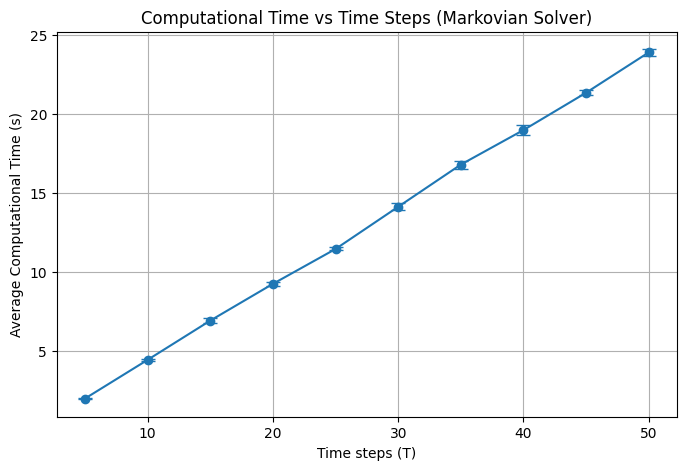

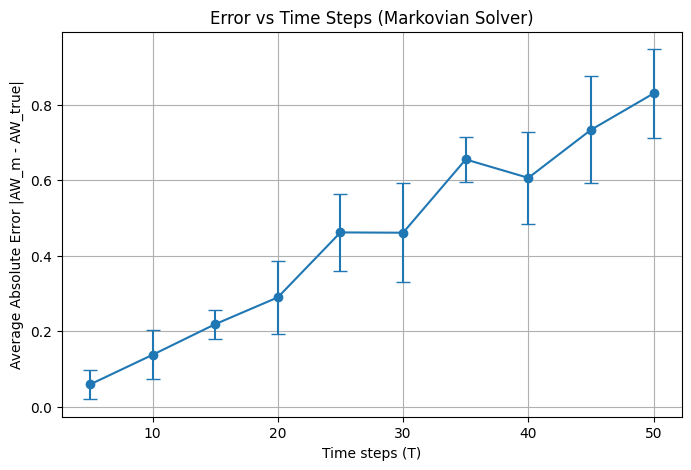

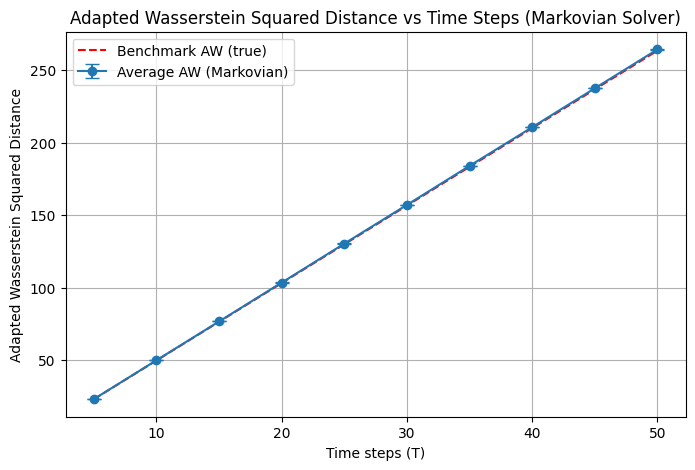

In [8]:
# 1. Plot average computational time vs. T with error bars.
plt.figure(figsize=(8, 5))
plt.errorbar(time_steps, avg_comp_time, yerr=std_comp_time, fmt='o-', capsize=5)
plt.xlabel("Time steps (T)")
plt.ylabel("Average Computational Time (s)")
plt.title("Computational Time vs Time Steps (Markovian Solver)")
plt.grid(True)
plt.show()

# 2. Plot average absolute error vs. T with error bars.
plt.figure(figsize=(8, 5))
plt.errorbar(time_steps, avg_error, yerr=std_error, fmt='o-', capsize=5)
plt.xlabel("Time steps (T)")
plt.ylabel("Average Absolute Error |AW_m - AW_true|")
plt.title("Error vs Time Steps (Markovian Solver)")
plt.grid(True)
plt.show()

# 3. Plot average adapted Wasserstein squared distance vs. T with error bars,
#    along with the benchmark (true) value as a dashed line.
plt.figure(figsize=(8, 5))
plt.errorbar(time_steps, avg_AW, yerr=std_AW, fmt='o-', capsize=5, label="Average AW (Markovian)")
plt.plot(time_steps, true_AW_list, 'r--', label="Benchmark AW (true)")
plt.xlabel("Time steps (T)")
plt.ylabel("Adapted Wasserstein Squared Distance")
plt.title("Adapted Wasserstein Squared Distance vs Time Steps (Markovian Solver)")
plt.legend()
plt.grid(True)
plt.show()

## Example 3: Markovian Process without Closed-Form (Black–Scholes)

We apply the solver to two correlated Black–Scholes asset paths over 30 days. No analytical adapted-Wasserstein distance is known, so we infer convergence via simulation.

## Setup

In [ ]:
def bs_simulation(n_sample, T, mu, sigma, dt, seed):
    np.random.seed(seed)
    # Initialize: (T+1, n_sample)
    X = np.zeros((T+1, n_sample))
    X[0, :] = 100.0  # Initial condition
    for t in range(1, T+1):
        Z = np.random.normal(size=n_sample)
        X[t, :] = X[t-1, :] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    return X

In [10]:
# Simulation settings for a 1-month option (30 days)
T = 30             # 30 time steps (days)
dt = 1 / 365       # each time step represents one day (annualized time)

# Parameters for process X (safe asset, low volatility)
mu1 = 0.05         # annual drift of 5%
sigma1 = 0.15      # annual volatility of 15%

# Parameters for process Y (volatile asset, high volatility)
mu2 = 0.12         # annual drift of 12%
sigma2 = 0.50      # annual volatility of 50%

# Sample Sizes (Computational Budget)
sample_sizes = [30000, 50000, 100000, 200000, 400000, 700000, 1000000, 1300000]
n_runs = 10

## Experiments

In [14]:
results = {}

grid_size = 0.4

for n_sample in sample_sizes:
    distances_runs = np.zeros(n_runs)
    times_runs = np.zeros(n_runs)
    
    print(f"\nRunning experiments for sample size: {n_sample}")
    
    for run in range(n_runs):
        # Generate two independent seeds
        seed = np.random.randint(10000)
        
        # Simulate the BS processes
        X = bs_simulation(n_sample, T, mu1, sigma1, dt, seed)
        Y = bs_simulation(n_sample, T, mu2, sigma2, dt, seed)
        
        
        # Compute adapted Wasserstein squared distance using the updated parallel solver
        t_start = time.perf_counter()
        AW_2square = nested_ot(X, Y, grid_size, markovian = True, num_threads=150)  ## the difference in speed between markovian python and makrovian C++ is not that big
        elapsed = time.perf_counter() - t_start
        
        distances_runs[run] = AW_2square
        times_runs[run] = elapsed
        
        print(f"Run {run+1}: AW_2^2 = {AW_2square:.4f}, Time = {elapsed:.4f}s")
    
    results[n_sample] = {"distances": distances_runs, "times": times_runs}


Running experiments for sample size: 30000
Run 1: AW_2^2 = 1637.8132, Time = 0.7726s
Run 2: AW_2^2 = 1645.3538, Time = 0.5885s
Run 3: AW_2^2 = 1638.9398, Time = 0.5782s
Run 4: AW_2^2 = 1622.3471, Time = 0.5734s
Run 5: AW_2^2 = 1649.4038, Time = 0.5747s
Run 6: AW_2^2 = 1623.6349, Time = 0.5691s
Run 7: AW_2^2 = 1660.3661, Time = 0.5780s
Run 8: AW_2^2 = 1646.5166, Time = 0.5758s
Run 9: AW_2^2 = 1645.5004, Time = 0.5757s
Run 10: AW_2^2 = 1644.7197, Time = 0.5733s

Running experiments for sample size: 50000
Run 1: AW_2^2 = 1650.9734, Time = 0.8371s
Run 2: AW_2^2 = 1645.8142, Time = 0.8442s
Run 3: AW_2^2 = 1632.6088, Time = 0.8367s
Run 4: AW_2^2 = 1626.4853, Time = 0.8308s
Run 5: AW_2^2 = 1633.9961, Time = 0.8820s
Run 6: AW_2^2 = 1638.0146, Time = 0.8333s
Run 7: AW_2^2 = 1641.7260, Time = 0.8369s
Run 8: AW_2^2 = 1623.7064, Time = 0.8314s
Run 9: AW_2^2 = 1632.5493, Time = 0.9684s
Run 10: AW_2^2 = 1626.0299, Time = 0.8549s

Running experiments for sample size: 100000
Run 1: AW_2^2 = 1631.5274

Sample Size: 30000
  Mean AW_2^2: 1641.4595 ± 10.9129
  Mean Time: 0.5959s ± 0.0591s

Sample Size: 50000
  Mean AW_2^2: 1635.1904 ± 8.4812
  Mean Time: 0.8556s ± 0.0404s

Sample Size: 100000
  Mean AW_2^2: 1635.2686 ± 5.4694
  Mean Time: 1.5072s ± 0.0707s

Sample Size: 200000
  Mean AW_2^2: 1633.6811 ± 7.3891
  Mean Time: 2.9181s ± 0.1961s

Sample Size: 400000
  Mean AW_2^2: 1633.5558 ± 3.2669
  Mean Time: 5.4065s ± 0.1289s

Sample Size: 700000
  Mean AW_2^2: 1630.4775 ± 2.6160
  Mean Time: 9.0219s ± 0.3011s

Sample Size: 1000000
  Mean AW_2^2: 1631.7042 ± 1.2749
  Mean Time: 12.8457s ± 0.2441s

Sample Size: 1300000
  Mean AW_2^2: 1631.0117 ± 1.1691
  Mean Time: 16.2550s ± 0.2027s



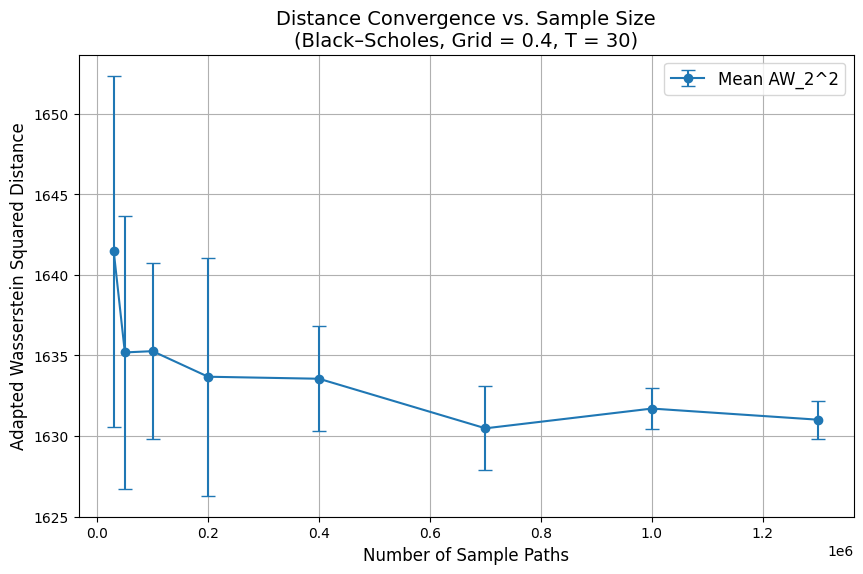

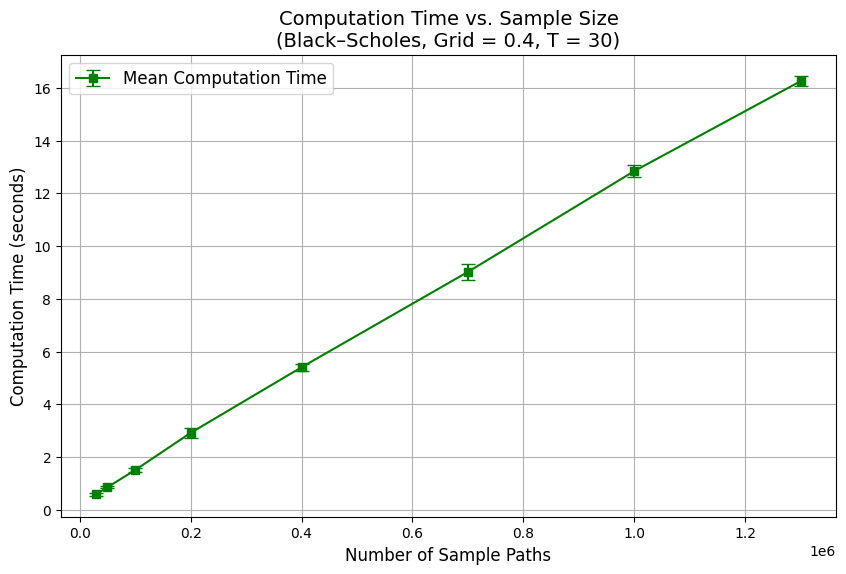

In [15]:
aggregated = {}
for n_sample in sorted(results.keys()):
    dists = results[n_sample]["distances"]
    times = results[n_sample]["times"]
    mean_dist = np.mean(dists)
    std_dist = np.std(dists)
    mean_time = np.mean(times)
    std_time = np.std(times)
    aggregated[n_sample] = {
        "mean_distance": mean_dist,
        "std_distance": std_dist,
        "mean_time": mean_time,
        "std_time": std_time
    }
    print(f"Sample Size: {n_sample}")
    print(f"  Mean AW_2^2: {mean_dist:.4f} ± {std_dist:.4f}")
    print(f"  Mean Time: {mean_time:.4f}s ± {std_time:.4f}s\n")

samples = sorted(aggregated.keys())
mean_distances = [aggregated[n]["mean_distance"] for n in samples]
std_distances = [aggregated[n]["std_distance"] for n in samples]
mean_times = [aggregated[n]["mean_time"] for n in samples]
std_times = [aggregated[n]["std_time"] for n in samples]

# Plot 1: Adapted AW_2^2 vs. Sample Size
plt.figure(figsize=(10, 6))
plt.errorbar(samples, mean_distances, yerr=std_distances, fmt="o-", capsize=5, label="Mean AW_2^2")
plt.xlabel("Number of Sample Paths", fontsize=12)
plt.ylabel("Adapted Wasserstein Squared Distance", fontsize=12)
plt.title("Distance Convergence vs. Sample Size\n(Black–Scholes, Grid = 0.4, T = 30)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Plot 2: Computation Time vs. Sample Size
plt.figure(figsize=(10, 6))
plt.errorbar(samples, mean_times, yerr=std_times, fmt="s-", capsize=5, color="green", label="Mean Computation Time")
plt.xlabel("Number of Sample Paths", fontsize=12)
plt.ylabel("Computation Time (seconds)", fontsize=12)
plt.title("Computation Time vs. Sample Size\n(Black–Scholes, Grid = 0.4, T = 30)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()